## Project Background
Autism Spectrum Disorder (ASD) affects communication and behavior. Early identification and intervention can significantly improve outcomes. This project aims to identify individuals who may be at higher risk for ASD based on commonly collected screening data (e.g., questionnaire responses, basic demographic information).

## Objective
The goal is to create a ML Ops tool that can do early detection for potential cases towards further clinical assessment, potentially speeding up the screening process and directing resources more effectively. This tool will predict the likelihood of an individual having Autism Spectrum Disorder (ASD) based on screening questionnaire data and demographic features, aiming for high sensitivity (recall) to minimize missed cases. This is a supervised binary classification problem (ASD vs. No ASD).

## Technical Background:
The model will use data from screenings to learn patterns in these features to distinguish between individuals diagnosed with ASD and those without.Technical challenges may involve preprocessing potentially imbalanced data, and ensuring fairness across different demographic groups by analyzing key metrics.
Evaluation will focus on classification performance metrics relevant to screening:
Primary Metrics: Recall (Sensitivity), AUC, PRC, Accuracy, Precision, F1-Score

Secondary Metrics: DIR, Relative Error, Force Plots. Correlation Plots.

Business/Clinical Relevance: Quantify the model's potential impact by simulating its use on a test set: calculate the percentage of true positive cases identified within the top X% of model predictions (e.g., top 20%), representing potential to accelerate workload for clinicians focusing on these high-risk individuals.


### Import libraries

In [13]:
import numpy as np 
import pandas as pd 
import boto3
import sagemaker
from pyathena import connect
import matplotlib.pyplot as plt
import seaborn as sns

### Load test and train dataset

In [14]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [15]:
train_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [16]:
test_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self


### Create AWS session

In [17]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [18]:
### Create and Push Data to S3 bucket

In [19]:
s3_private_path_tsv = "s3://{}/autism_prediction/tsv".format(bucket)
print(s3_private_path_tsv)

s3://sagemaker-us-east-1-553246940090/autism_prediction/tsv


In [20]:
!aws s3 cp "Autism_Prediction/test.csv" $s3_private_path_tsv/
!aws s3 cp "Autism_Prediction/train.csv" $s3_private_path_tsv/


The user-provided path Autism_Prediction/test.csv does not exist.

The user-provided path Autism_Prediction/train.csv does not exist.


### Create ASW S3 Athena Database

In [21]:
database_name = "dso_asd_v1"
s3_staging_dir = "s3://sagemaker-us-east-1-672518276407/autism_prediction/tsv"
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS dso_asd_v1


/tmp/ipykernel_205/873326040.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [22]:
statement = "SHOW DATABASES LIKE 'dso_asd_v1'"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

/tmp/ipykernel_205/2483888340.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,dso_asd_v1


In [23]:
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [24]:
import awswrangler as wr

# Database name
database_name = "dso_asd_v1_parquet"

# Create the Glue database if it doesn't exist
try:
    wr.catalog.create_database(name=database_name)
    print(f"Database '{database_name}' created successfully or already exists.")
except Exception as e:
    print(f"Error creating database: {e}")

Database 'dso_asd_v1_parquet' created successfully or already exists.


In [25]:
# S3 bucket and file path for Parquet
bucket_name = "sagemaker-us-east-1-672518276407"
parquet_path = f"s3://{bucket_name}/autism_prediction/parquet/asd_dataset.parquet" 

# Save DataFrame as Parquet to S3
try:
    wr.s3.to_parquet(
        df=train_df,
        path=parquet_path,
        dataset=True,
        mode="overwrite",
        database=database_name,
        table="asd_parquet"
    )
    print(f"Data uploaded successfully to {parquet_path} as Parquet.")
except Exception as e:
    print(f"Error uploading DataFrame to S3: {e}")

2025-06-19 18:50:27,560	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 411021312 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.90gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-06-19 18:50:27,823	INFO worker.py:1852 -- Started a local Ray instance.


Data uploaded successfully to s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet as Parquet.


In [26]:
# List all tables in the specified database
try:
    tables = list(wr.catalog.get_tables(database=database_name))
    print("Tables in the database:")
    for table in tables:
        print(f"- {table['Name']}")
except Exception as e:
    print(f"Error retrieving tables: {e}")

Tables in the database:
- asd_parquet


### Query the data from AWS Athena DB

In [27]:
# Query the table to check if the data is loaded
try:
    query = f"SELECT * FROM {database_name}.asd_parquet LIMIT 5"
    df_sample = wr.athena.read_sql_query(query, database=database_name)
    print("Data from the ASD Athena table:")
    print(df_sample)
except Exception as e:
    print(f"Error querying table: {e}")

Data from the ASD Athena table:
   id  a1_score  a2_score  a3_score  a4_score  a5_score  a6_score  a7_score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   a8_score  a9_score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation class

### Plotting diagrams

<Axes: xlabel='Class/ASD', ylabel='age'>

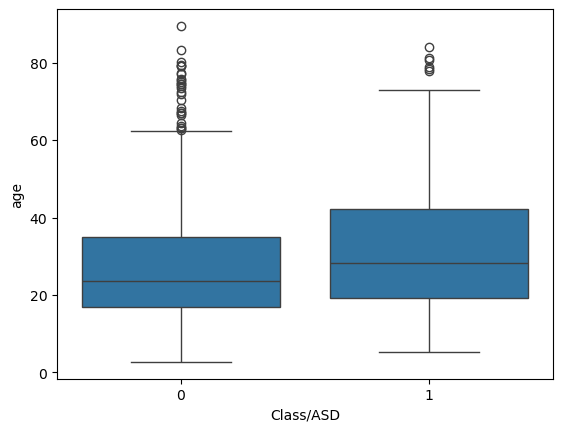

In [28]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['age'])

<Axes: xlabel='age', ylabel='Count'>

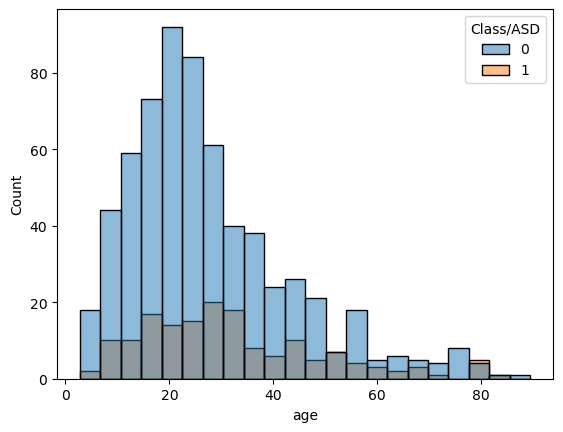

In [29]:
sns.histplot(x = train_df['age'], hue = train_df['Class/ASD'])

<Axes: xlabel='Class/ASD', ylabel='result'>

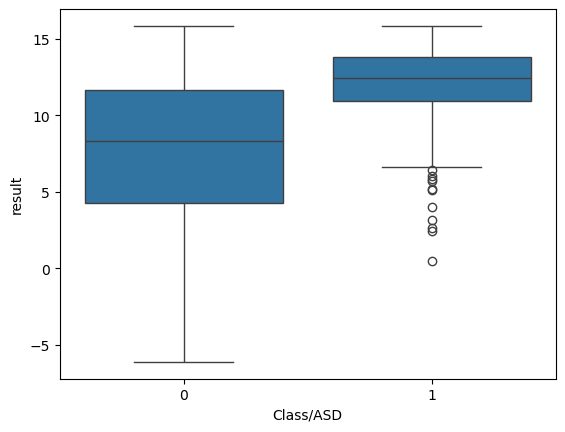

In [30]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['result'])

In [34]:
def get_num_cat_cols(df):
    num_cls = [x for x in df.columns if df[x].dtype != 'object']
    cat_cls = [x for x in df.columns if x not in num_cls]

    print(f'Numerical columns \n',num_cls)
    print(f'Categorical columns \n',cat_cls)
    
    return num_cls, cat_cls
num_cols, cat_cols = get_num_cat_cols(train_df)

Numerical columns 
 ['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result', 'Class/ASD']
Categorical columns 
 ['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc', 'relation']


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def cat_col_test(df, cat_colname, target_colname):
    print(f"Column name : {cat_colname}")

    # Contingency table
    ct = pd.crosstab(df[cat_colname], df[target_colname])
    print("\nContingency Table:\n", ct)

    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"\nChi-square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies:\n{expected}")

    # Interpretation
    alpha = 0.05
    if p < alpha:
        print(f"Significant relationship (p={p:.4f}) between '{cat_colname}' and '{target_colname}'")
    else:
        print(f"No significant relationship (p={p:.4f}) between '{cat_colname}' and '{target_colname}'")

    # Plot
    ax = ct.plot(kind='bar', stacked=True, rot=45)
    ax.legend(title=target_colname, bbox_to_anchor=(1, 1.02), loc='upper left')

    for c in ax.containers:
        ax.bar_label(c, label_type='center', fontsize=8)
    plt.tight_layout()
    plt.show()


Column name : gender

Contingency Table:
 Class/ASD    0    1
gender             
f          215   55
m          424  106

Chi-square Statistic: 0.0009
P-value: 0.9758
Degrees of Freedom: 1
Expected Frequencies:
[[215.6625  54.3375]
 [423.3375 106.6625]]
No significant relationship (p=0.9758) between 'gender' and 'Class/ASD'


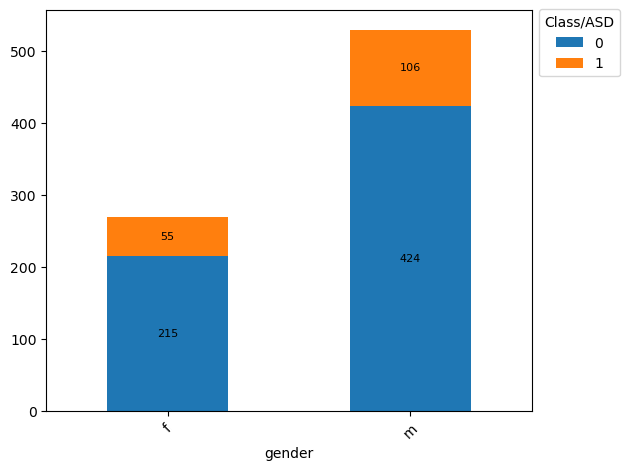

Column name : ethnicity

Contingency Table:
 Class/ASD          0    1
ethnicity                
?                196    7
Asian             63    4
Black             41    6
Hispanic           7    2
Latino            13    4
Middle Eastern    91    6
Others            27    2
Pasifika          26    6
South Asian       31    3
Turkish            5    0
White-European   136  121
others             3    0

Chi-square Statistic: 181.0167
P-value: 0.0000
Degrees of Freedom: 11
Expected Frequencies:
[[162.14625  40.85375]
 [ 53.51625  13.48375]
 [ 37.54125   9.45875]
 [  7.18875   1.81125]
 [ 13.57875   3.42125]
 [ 77.47875  19.52125]
 [ 23.16375   5.83625]
 [ 25.56      6.44   ]
 [ 27.1575    6.8425 ]
 [  3.99375   1.00625]
 [205.27875  51.72125]
 [  2.39625   0.60375]]
Significant relationship (p=0.0000) between 'ethnicity' and 'Class/ASD'


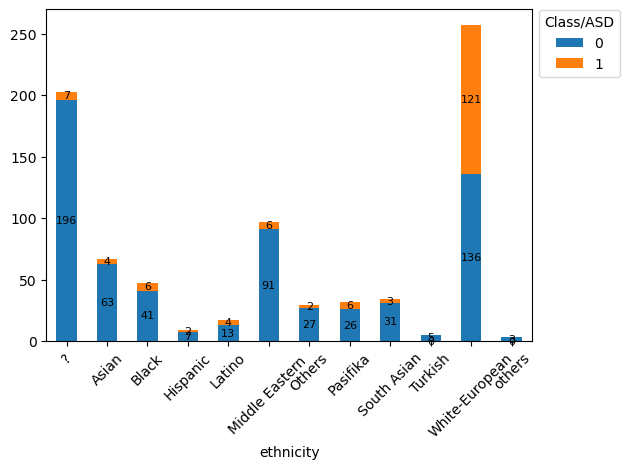

Column name : jaundice

Contingency Table:
 Class/ASD    0    1
jaundice           
no         510  105
yes        129   56

Chi-square Statistic: 14.5987
P-value: 0.0001
Degrees of Freedom: 1
Expected Frequencies:
[[491.23125 123.76875]
 [147.76875  37.23125]]
Significant relationship (p=0.0001) between 'jaundice' and 'Class/ASD'


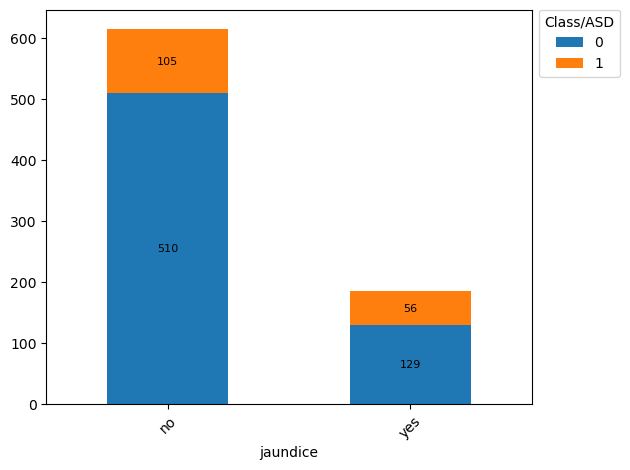

Column name : austim

Contingency Table:
 Class/ASD    0   1
austim            
no         577  92
yes         62  69

Chi-square Statistic: 100.8225
P-value: 0.0000
Degrees of Freedom: 1
Expected Frequencies:
[[534.36375 134.63625]
 [104.63625  26.36375]]
Significant relationship (p=0.0000) between 'austim' and 'Class/ASD'


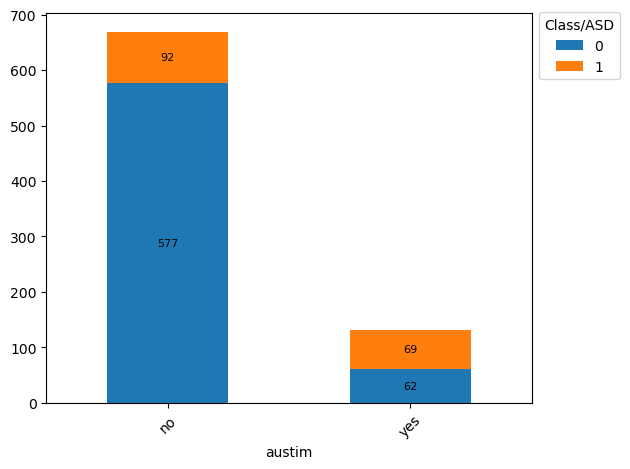

Column name : contry_of_res

Contingency Table:
 Class/ASD               0   1
contry_of_res                
Afghanistan            19   3
AmericanSamoa           4   0
Angola                  1   0
Argentina               1   0
Armenia                 2   2
Aruba                   2   2
Australia              30   7
Austria                17   1
Azerbaijan              2   2
Bahamas                 5   1
Bangladesh              1   0
Belgium                 1   0
Bolivia                 2   1
Brazil                 11   1
Burundi                 0   1
Canada                 21   9
China                   4   0
Cyprus                  1   1
Czech Republic          1   0
Egypt                   1   0
Ethiopia                2   1
France                  7   3
Germany                 3   0
Hong Kong               1   0
Iceland                 3   0
India                 105   3
Iran                    7   1
Iraq                    4   0
Ireland                 7   2
Italy                

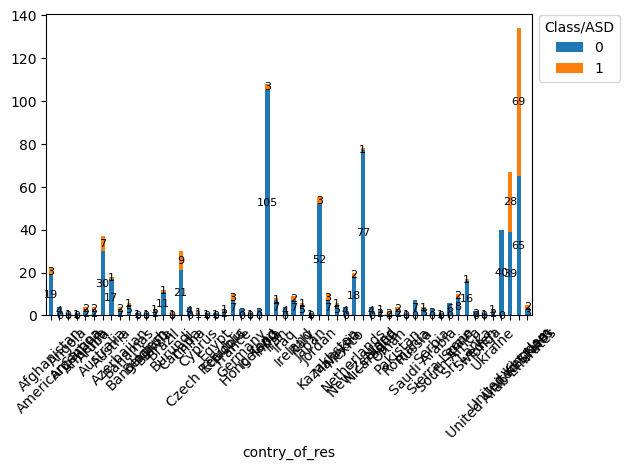

Column name : used_app_before

Contingency Table:
 Class/ASD          0    1
used_app_before          
no               602  148
yes               37   13

Chi-square Statistic: 0.7885
P-value: 0.3746
Degrees of Freedom: 1
Expected Frequencies:
[[599.0625 150.9375]
 [ 39.9375  10.0625]]
No significant relationship (p=0.3746) between 'used_app_before' and 'Class/ASD'


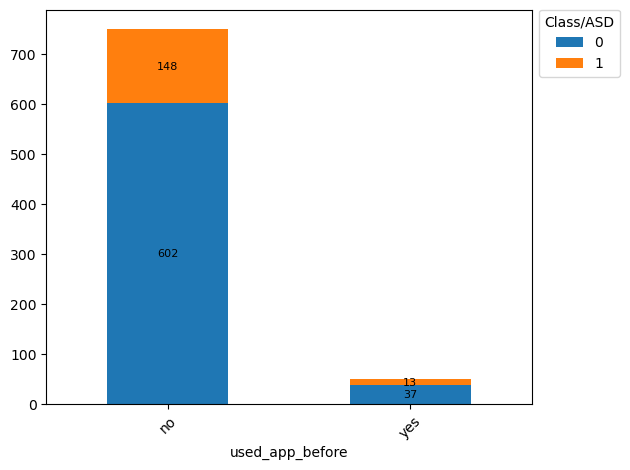

Column name : age_desc

Contingency Table:
 Class/ASD      0    1
age_desc             
18 and more  639  161

Chi-square Statistic: 0.0000
P-value: 1.0000
Degrees of Freedom: 0
Expected Frequencies:
[[639. 161.]]
No significant relationship (p=1.0000) between 'age_desc' and 'Class/ASD'


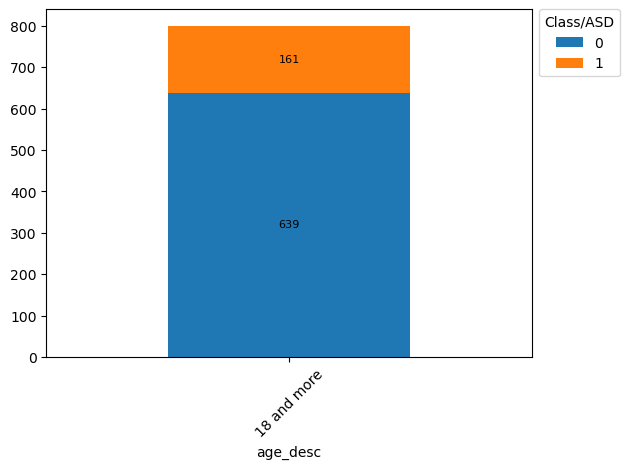

Column name : relation

Contingency Table:
 Class/ASD                   0    1
relation                          
?                          39    1
Health care professional    1    1
Others                      2    0
Parent                     21    8
Relative                   14    4
Self                      562  147

Chi-square Statistic: 10.5611
P-value: 0.0608
Degrees of Freedom: 5
Expected Frequencies:
[[3.1950000e+01 8.0500000e+00]
 [1.5975000e+00 4.0250000e-01]
 [1.5975000e+00 4.0250000e-01]
 [2.3163750e+01 5.8362500e+00]
 [1.4377500e+01 3.6225000e+00]
 [5.6631375e+02 1.4268625e+02]]
No significant relationship (p=0.0608) between 'relation' and 'Class/ASD'


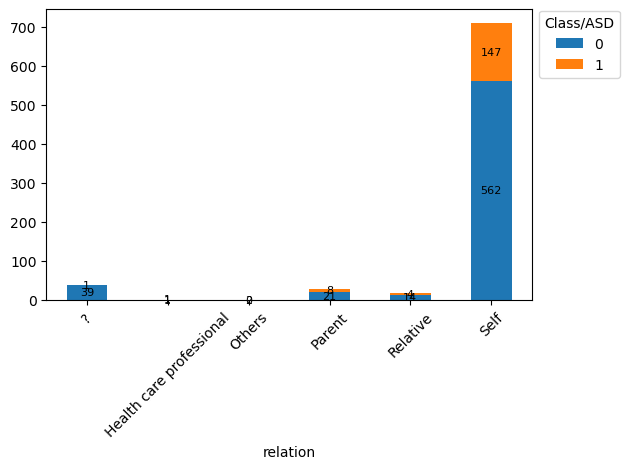

In [40]:
for col in cat_cols:
    cat_col_test(train_df, col, 'Class/ASD')

## Create the feature group

In [42]:
import boto3
import pandas as pd
import time
import uuid
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role

# --- Configuration ---
s3_parquet_uri = "s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet"
bucket_prefix = "autism-feature-store"
record_identifier_feature_name = "record_id"
event_time_feature_name = "event_time"
feature_group_name = f"asd-feature-group-{uuid.uuid4().hex[:8]}"

# --- Initialize Session and Clients ---
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client("sagemaker")
featurestore_runtime = boto_session.client("sagemaker-featurestore-runtime")

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

default_s3_bucket = feature_store_session.default_bucket()

# --- Load Parquet from S3 ---
df = pd.read_parquet(s3_parquet_uri)
print(f"Loaded Parquet file from {s3_parquet_uri} with shape: {df.shape}")

# --- Prepare Data ---
df.columns = [c.strip().replace(" ", "_").replace("<", "less_than_") for c in df.columns]

# Add required columns
if record_identifier_feature_name not in df.columns:
    df.insert(0, record_identifier_feature_name, range(1, 1 + len(df)))

if event_time_feature_name not in df.columns:
    df[event_time_feature_name] = pd.Timestamp.now().strftime("%Y-%m-%dT%H:%M:%SZ")

# --- Create Feature Group ---
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)
feature_group.load_feature_definitions(data_frame=df)

role_arn = get_execution_role()

feature_group.create(
    s3_uri=f"s3://{default_s3_bucket}/{bucket_prefix}/offline_store",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role_arn,
    enable_online_store=True
)

# --- Wait for Feature Group to be Active ---
def wait_for_feature_group_creation_complete(fg):
    status = fg.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group creation...")
        time.sleep(5)
        status = fg.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Feature Group creation failed: {status}")
    print(f"Feature Group '{fg.name}' created successfully.")

wait_for_feature_group_creation_complete(feature_group)

# --- Ingest Records into Feature Store ---
records = df.to_dict(orient="records")

for record in records:
    featurestore_runtime.put_record(
        FeatureGroupName=feature_group_name,
        Record=[{"FeatureName": k, "ValueAsString": str(v)} for k, v in record.items()]
    )

print(f" Data ingestion completed for Feature Group: {feature_group_name}")


Loaded Parquet file from s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet with shape: (800, 22)
Waiting for Feature Group creation...
Waiting for Feature Group creation...
Waiting for Feature Group creation...
Waiting for Feature Group creation...
Feature Group 'asd-feature-group-55aa5b50' created successfully.
 Data ingestion completed for Feature Group: asd-feature-group-55aa5b50


### Query online values from feature group

In [45]:
import boto3

# --- Configuration ---
feature_group_name = "asd-feature-group-55aa5b50"  
# Assuming this line already exists:
records = df.to_dict(orient="records")

# Extract all record_id values
record_ids = [record["record_id"] for record in records]


# --- Initialize Feature Store Runtime Client ---
region = boto3.Session().region_name
featurestore_runtime = boto3.client("sagemaker-featurestore-runtime", region_name=region)

# --- Query from Online Store ---
response = featurestore_runtime.get_record(
    FeatureGroupName=feature_group_name,
    RecordIdentifierValueAsString=str(record_ids[0])
)

# --- Process and Print Results ---
if "Record" in response:
    record_values = {item['FeatureName']: item['ValueAsString'] for item in response['Record']}
    print("Record fetched from Online Store:")
    for key, value in record_values.items():
        print(f"{key}: {value}")
else:
    print("Record not found in Online Store.")


Record fetched from Online Store:
record_id: 1
id: 1
a1_score: 1
a2_score: 0
a3_score: 1
a4_score: 0
a5_score: 1
a6_score: 0
a7_score: 1
a8_score: 0
a9_score: 1
a10_score: 1
age: 38.17274623
gender: f
ethnicity: ?
jaundice: no
austim: no
contry_of_res: Austria
used_app_before: no
result: 6.351165589
age_desc: 18 and more
relation: Self
class_asd: 0
event_time: 2025-06-19T19:42:10Z


## Build and train dataset from Online store using RandomForestClassifier

In [84]:
import boto3
import pandas as pd
import time
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib


# --- Config ---
feature_group_name = "asd-feature-group-55aa5b50"  
record_identifier_feature_name = "record_id"
target_column = "class_asd"  # Label column
region = boto3.Session().region_name

# --- Initialize Feature Store Runtime Client ---
featurestore_runtime = boto3.client("sagemaker-featurestore-runtime", region_name=region)

# --- Generate Sample Record IDs (adjust as needed) ---
record_ids = list(range(1, 101))  # Simulate 100 known record_ids: 1 to 100

# --- Fetch Records from Online Store ---
fetched_data = []
print("Fetching records from Online Store...")

for rid in record_ids:
    try:
        response = featurestore_runtime.get_record(
            FeatureGroupName=feature_group_name,
            RecordIdentifierValueAsString=str(rid)
        )
        if "Record" in response:
            row = {item['FeatureName']: item['ValueAsString'] for item in response['Record']}
            fetched_data.append(row)
        else:
            print(f"Record ID {rid} not found.")
    except Exception as e:
        print(f"Error fetching record ID {rid}: {str(e)}")
    time.sleep(0.1)  # prevent throttling

print(f" Fetched {len(fetched_data)} records from Online Store")

# --- Create DataFrame ---
df_online = pd.DataFrame(fetched_data)

# --- Clean Column Names ---
df_online.columns = df_online.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)

# --- Drop unnecessary or identifier columns ---
drop_cols = ["record_id", "event_time", "id", "age_desc", "contry_of_res", "relation"]
df_online.drop(columns=drop_cols, inplace=True, errors="ignore")

# --- Encode categorical columns ---
for col in df_online.columns:
    if df_online[col].dtype == "object":
        df_online[col] = df_online[col].astype("category").cat.codes

# --- Ensure target is numeric ---
if target_column not in df_online.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset.")

df_online[target_column] = df_online[target_column].astype(int)

# --- Split into features and target ---
X = df_online.drop(columns=[target_column])
y = df_online[target_column]

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train RandomForestClassifier ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save model (compatible format)
joblib.dump(clf, "model.joblib")

# --- Predict and Evaluate ---
y_pred = clf.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Fetching records from Online Store...
 Fetched 100 records from Online Store

 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.50      0.50      0.50         2

    accuracy                           0.90        20
   macro avg       0.72      0.72      0.72        20
weighted avg       0.90      0.90      0.90        20



## Create a Model store from the previously created RandomForestClassifier model

In [85]:
import joblib
import os
import tarfile
import boto3
import sagemaker
from sagemaker import get_execution_role


# --- SageMaker + S3 Setup ---
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = get_execution_role()
prefix = "autism-model-store"
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# --- Save model locally ---
model_file = os.path.join(model_dir, "model.joblib")
joblib.dump(clf, model_file)

# --- Package as model.tar.gz (SageMaker expects this format) ---
tar_file = os.path.join(model_dir, "model.tar.gz")
with tarfile.open(tar_file, mode="w:gz") as tar:
    tar.add(model_file, arcname="model.joblib")

# --- Upload to S3 ---
model_artifact_s3_uri = sagemaker_session.upload_data(tar_file, bucket=bucket, key_prefix=prefix)
print(f" Uploaded model.tar.gz to S3: {model_artifact_s3_uri}")


 Uploaded model.tar.gz to S3: s3://sagemaker-us-east-1-553246940090/autism-model-store/model.tar.gz


### Register model to SageMaker Model store

In [86]:
# --- Create Model Package Group (if not exists) ---
client = boto3.client("sagemaker", region_name=region)
model_package_group_name = "AutismClassifierPackageGroupV2"

try:
    client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription="RandomForestClassifier for ASD detection"
    )
    print(f"Created Model Package Group: {model_package_group_name}")
except client.exceptions.ResourceInUse:
    print(f"Model Package Group '{model_package_group_name}' already exists.")

# --- Register the model ---
model_package_response = client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription="ASD prediction model using RandomForestClassifier",
    InferenceSpecification={
        "Containers": [
            {
                "Image": sagemaker.image_uris.retrieve(
                    framework="sklearn", region=region, version="1.0-1"
                ),
                "ModelDataUrl": model_artifact_s3_uri,
            }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"]
    },
    ModelApprovalStatus="PendingManualApproval"
)

print(f"Model registered to Model Package Group '{model_package_group_name}'")


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Created Model Package Group: AutismClassifierPackageGroupV2
Model registered to Model Package Group 'AutismClassifierPackageGroupV2'


In [87]:
print("Model ARN:", model_package_response["ModelPackageArn"])

Model ARN: arn:aws:sagemaker:us-east-1:553246940090:model-package/AutismClassifierPackageGroupV2/1


In [88]:
model_package_arn = model_package_response["ModelPackageArn"]

## Create a model endpoint

### Set the Model status to Approved

In [89]:
response = sm_client.list_model_packages(
    ModelPackageGroupName="AutismClassifierPackageGroupV1",
    SortBy="CreationTime",
    SortOrder="Descending",
    MaxResults=1
)

model_package_arn = response["ModelPackageSummaryList"][0]["ModelPackageArn"]
print(f"Latest Model Package ARN: {model_package_arn}")


Latest Model Package ARN: arn:aws:sagemaker:us-east-1:553246940090:model-package/AutismClassifierPackageGroupV1/1


In [66]:
sm_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus="Approved",
    ApprovalDescription="Manually approved for endpoint deployment"
)

print(f"Model Package approved: {model_package_arn}")

Model Package approved: arn:aws:sagemaker:us-east-1:553246940090:model-package/AutismClassifierPackageGroupV1/1


### Create an model deployment

In [68]:
import boto3
import time
import sagemaker
from sagemaker import get_execution_role

# --- Config ---
region = boto3.Session().region_name
sm_client = boto3.client("sagemaker", region_name=region)
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# --- Use the latest approved model package ARN from the registry ---

# Get the latest approved model package
response = sm_client.list_model_packages(
    ModelPackageGroupName="AutismClassifierPackageGroupV1",
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    SortOrder="Descending",
    MaxResults=1
)


if not response["ModelPackageSummaryList"]:
    raise ValueError("No approved model found. Approve one in SageMaker Model Registry first.")

model_package_arn = response["ModelPackageSummaryList"][0]["ModelPackageArn"]
print(f"Using Model Package ARN: {model_package_arn}")


Using Model Package ARN: arn:aws:sagemaker:us-east-1:553246940090:model-package/AutismClassifierPackageGroupV1/1


In [69]:
# --- Unique names for endpoint and config ---
endpoint_name = f"asd-classifier-endpoint-{int(time.time())}"
model_name = f"asd-classifier-model-{int(time.time())}"
endpoint_config_name = f"{endpoint_name}-config"

# --- Create Model from Model Package ---
sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "ModelPackageName": model_package_arn
    }
)
print(f"Created model: {model_name}")

# --- Create Endpoint Configuration ---
sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "InitialInstanceCount": 1,
            "InstanceType": "ml.m5.large",
            "InitialVariantWeight": 1
        }
    ]
)
print(f"Created endpoint config: {endpoint_config_name}")

# --- Deploy the Endpoint ---
sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)
print(f"Creating endpoint: {endpoint_name} (this may take a few minutes...)")


Created model: asd-classifier-model-1750372611
Created endpoint config: asd-classifier-endpoint-1750372611-config
Creating endpoint: asd-classifier-endpoint-1750372611 (this may take a few minutes...)


### Wait for the endpoint creation to complete

In [ ]:
import time

def wait_for_endpoint(endpoint_name):
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    while status not in ["InService", "Failed"]:
        print(f"Endpoint status: {status}. Waiting...")
        time.sleep(15)
        status = sm_client.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status == "InService":
        print(f"Endpoint '{endpoint_name}' is InService and ready!")
    else:
        raise RuntimeError(f"Endpoint creation failed with status: {status}")

wait_for_endpoint(endpoint_name)

### Model deployment failure troubleshooting
The model deployment failed, so running few steps to make it succeeded

In [75]:
import joblib
import os
import pandas as pd
from sagemaker.sklearn.model import SKLearnModel

def model_fn(model_dir):
    model_path = os.path.join(model_dir, "model.joblib")
    return joblib.load(model_path)

def input_fn(request_body, request_content_type):
    if request_content_type == "text/csv":
        return pd.read_csv(pd.compat.StringIO(request_body), header=None)
    raise ValueError("Unsupported content type: {}".format(request_content_type))

def predict_fn(input_data, model):
    return model.predict(input_data)

def output_fn(prediction, content_type):
    if content_type == "text/csv":
        return ",".join(str(x) for x in prediction)
    raise ValueError("Unsupported content type: {}".format(content_type))

In [80]:
import tarfile

with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("model/model.joblib", arcname="model.joblib")
    tar.add("model/code/inference.py", arcname="code/inference.py")


In [81]:
from sagemaker import Session

sagemaker_session = Session()
s3_model_path = sagemaker_session.upload_data("model.tar.gz", key_prefix="autism-model/fixed")
print("\nUploaded model with correct inference script:", s3_model_path)



Uploaded model with correct inference script: s3://sagemaker-us-east-1-553246940090/autism-model/fixed/model.tar.gz


In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import joblib

X, y = load_iris(return_X_y=True)
model = RandomForestClassifier()
model.fit(X, y)

joblib.dump(model, "model.joblib")

['model.joblib']

## Using XGBoost model

In [106]:
from datetime import datetime
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig, CronExpressionGenerator
from sagemaker.model_monitor import ModelQualityMonitor, MonitoringDatasetFormat
from sagemaker.image_uris import retrieve
from sagemaker.session import Session

# --- Initialize session ---
role = get_execution_role()
sagemaker_session = Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/xgb-monitoring"

# --- Paths ---
timestamp = datetime.utcnow().strftime("%Y-%m-%d-%H%M")
#model_s3_path = f"s3://{bucket}/{prefix}/model/xgb-churn-prediction-model.tar.gz"
model_s3_path = "s3://sagemaker-us-east-1-553246940090/autism-model-store/model.tar.gz"
endpoint_name = f"xgb-monitor-endpoint-{timestamp}"
capture_path = f"s3://{bucket}/{prefix}/capture"
report_path = f"s3://{bucket}/{prefix}/reports"
ground_truth_path = f"s3://{bucket}/{prefix}/ground-truth/{timestamp}"

# --- Deploy model with data capture ---
image_uri = retrieve("xgboost", region=region, version="0.90-1")
model = Model(
    image_uri=image_uri,
    model_data=model_s3_path,
    role=role,
    sagemaker_session=sagemaker_session
)

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=capture_path
)

model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config
)

print(f"Endpoint '{endpoint_name}' deployed with data capture enabled.")

# --- Set up Model Quality Monitor ---
monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=sagemaker_session
)

schedule_name = f"xgb-model-quality-monitoring-{timestamp}"


/tmp/ipykernel_205/3182243152.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y-%m-%d-%H%M")
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-06-21-06-18-19-782
INFO:sagemaker:Creating endpoint-config with name xgb-monitor-endpoint-2025-06-21-0618
INFO:sagemaker:Creating endpoint with name xgb-monitor-endpoint-2025-06-21-0618


-----!

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Endpoint 'xgb-monitor-endpoint-2025-06-21-0618' deployed with data capture enabled.


## Monitoring setup

To perform the monitoring setup, we will follow the below steps:
* Setup Baseline Job using training data
* Create a monitoring schedule
* View Monitoring Reports
* View Monitoring Status

In [73]:
import pandas as pd
import boto3
import sagemaker

# --- Load Parquet ---
parquet_s3_uri = "s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet"
df = pd.read_parquet(parquet_s3_uri)

# --- Save as CSV ---
csv_file = "asd_dataset.csv"
df.to_csv(csv_file, index=False)

# --- Upload CSV to S3 ---
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
upload_prefix = "autism_prediction/csv"

csv_s3_uri = sagemaker_session.upload_data(
    path=csv_file,
    bucket=bucket,
    key_prefix=upload_prefix
)

print(f"CSV uploaded: {csv_s3_uri}")


CSV uploaded: s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/asd_dataset.csv


In [74]:
# Setup Baseline Job

from sagemaker.model_monitor import DefaultModelMonitor, DatasetFormat
from sagemaker import get_execution_role

role = get_execution_role()

monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=sagemaker_session
)

baseline_output_uri = f"s3://{bucket}/monitoring/baseline-output"

monitor.suggest_baseline(
    baseline_dataset=csv_s3_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_output_uri,
    wait=True
)

print("Baseline job completed. Statistics and constraints are stored.")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2025-06-19-23-16-57-307


...............2025-06-19 23:19:28.005924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-19 23:19:28.005963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-19 23:19:29.667966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-19 23:19:29.667997: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-19 23:19:29.668057: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-2-223-201.ec2.internal): /proc/driver/nvidia/version does not exist
2025-06-19 23:19:29.668355: I ten

In [136]:
job_definition_name = "DEMO-xgb-churn-model-quality-jobdef-2025-06-21-2015-v2"
baseline_constraints_s3_uri = "s3://sagemaker-us-east-1-553246940090/autism_prediction/reports/constraints.json"
monitoring_output_s3_uri = "s3://sagemaker-us-east-1-553246940090/autism_prediction/reports/output"
ground_truth_s3_uri = "s3://sagemaker-us-east-1-553246940090/autism_prediction/ground-truth/labels.csv"
endpoint_name = "xgb-monitor-endpoint-2025-06-21-0618"

response = sm_client.create_model_quality_job_definition(
    JobDefinitionName=job_definition_name,
    ModelQualityAppSpecification={
        'ImageUri': image_uri,
        'ProblemType': 'BinaryClassification'
    },
    ModelQualityJobInput={
        'EndpointInput': {
            'EndpointName': endpoint_name,
            'LocalPath': '/opt/ml/processing/input/endpoint',
            'S3InputMode': 'File',
            'S3DataDistributionType': 'FullyReplicated',
            'InferenceAttribute': 'predicted_label' 
        },
        'GroundTruthS3Input': {
            'S3Uri': ground_truth_s3_uri
        }
    },
    ModelQualityJobOutputConfig={
        'MonitoringOutputs': [{
            'S3Output': {
                'S3Uri': monitoring_output_s3_uri,
                'LocalPath': '/opt/ml/processing/output',
                'S3UploadMode': 'EndOfJob'
            }
        }]
    },
    JobResources={
        'ClusterConfig': {
            'InstanceCount': 1,
            'InstanceType': 'ml.m5.large',
            'VolumeSizeInGB': 20
        }
    },
    StoppingCondition={  
        'MaxRuntimeInSeconds': 1800
    },
    RoleArn=role
)
print(f'Monitoring Job Definition created successfully {job_definition_name}') 

Monitoring Job Definition created successfully DEMO-xgb-churn-model-quality-jobdef-2025-06-21-2015-v2


In [137]:
sm_client.create_monitoring_schedule(
    MonitoringScheduleName=schedule_name,
    MonitoringScheduleConfig={
        'ScheduleConfig': {
            'ScheduleExpression': 'cron(0 */1 ? * * *)'
        },
        'MonitoringJobDefinitionName': 'DEMO-xgb-churn-model-quality-jobdef-2025-06-21-2015-v2',
        'MonitoringType': 'ModelQuality'
    }
)

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:553246940090:monitoring-schedule/DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1',
 'ResponseMetadata': {'RequestId': '216b4422-60fc-488c-bae3-0a2e38f2605b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '216b4422-60fc-488c-bae3-0a2e38f2605b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '142',
   'date': 'Sat, 21 Jun 2025 16:43:00 GMT'},
  'RetryAttempts': 0}}

In [138]:
# View Monitoring status

boto3.client("sagemaker").describe_monitoring_schedule(MonitoringScheduleName=schedule_name)

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:553246940090:monitoring-schedule/DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1',
 'MonitoringScheduleName': 'DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1',
 'MonitoringScheduleStatus': 'Scheduled',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2025, 6, 21, 16, 43, 0, 645000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 6, 21, 16, 43, 5, 424000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 */1 ? * * *)'},
  'MonitoringJobDefinitionName': 'DEMO-xgb-churn-model-quality-jobdef-2025-06-21-2015-v2',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'xgb-monitor-endpoint-2025-06-21-0618',
 'ResponseMetadata': {'RequestId': '06df83c3-29b9-4ea8-a1ff-83a5beab8c69',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '06df83c3-29b9-4ea8-a1ff-83a5beab8c69',
   'content-type': 'application/x-amz-json-1.1',
   'content-

## Model drift and feature drift

To monitor the model performance, we need to monitor the model drift and feature drift over time

In [139]:
import pandas as pd
from datetime import datetime
from IPython.display import display
import boto3

# Load constraint and statistics report (latest)
bucket = "sagemaker-us-east-1-553246940090"
prefix = "autism_prediction/reports/output"
s3_path = f"s3://{bucket}/{prefix}"

# We'll use Boto3 to list the files in the output report path
s3 = boto3.client("s3")

# List objects in the monitoring output directory
result = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
report_files = [content['Key'] for content in result.get('Contents', []) if content['Key'].endswith("constraints.json") or content['Key'].endswith("statistics.json")]

report_files

[]

In [145]:
import boto3

sm_client = boto3.client("sagemaker")
schedule_name = "DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1"

response = sm_client.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
print("Status:", response["MonitoringScheduleStatus"])
print("Last Modified:", response["LastModifiedTime"])


Status: Scheduled
Last Modified: 2025-06-21 17:08:02.422000+00:00


In [147]:
response = sm_client.list_monitoring_executions(MonitoringScheduleName=schedule_name)
executions = response["MonitoringExecutionSummaries"]

if executions:
    for job in executions:
        print(f"Status: {job['MonitoringExecutionStatus']}")
        print(f"Start: {job['CreationTime']} | End: {job.get('EndTime', 'N/A')}")
else:
    print("No executions found. We need to wait for the job execution to complete.")

Status: Pending
Start: 2025-06-21 17:08:02.413000+00:00 | End: N/A


| Check Type     | Source File                              | What It Analyzes                            |
| -------------- | ---------------------------------------- | ------------------------------------------- |
| Accuracy Drift | `constraints.json`                       | Constraint violations (e.g., accuracy drop) |
| Feature Drift  | `statistics.json`                        | Drift on individual input features          |
| Model Drift    | Inferred via drift or violation patterns |                                             |


In [149]:
import boto3
import json
import tempfile
import os

# --- CONFIG ---
bucket_name = "sagemaker-us-east-1-553246940090"
monitoring_output_prefix = "autism_prediction/reports/output"  

# --- Initialize S3 client ---
s3 = boto3.client("s3")

# --- Utility to download a file from S3 ---
def download_s3_file(bucket, key):
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        s3.download_file(bucket, key, tmp_file.name)
        with open(tmp_file.name, "r") as f:
            content = json.load(f)
        os.unlink(tmp_file.name)
    return content

# --- Locate latest output folder ---
def list_latest_monitoring_output(bucket, prefix):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    keys = sorted(
        [item["Key"] for item in response.get("Contents", []) if item["Key"].endswith("constraints.json")]
    )
    if not keys:
        raise Exception("No constraints.json files found.")
    latest_constraints_key = keys[-1]
    latest_base = os.path.dirname(latest_constraints_key)
    return latest_base

latest_prefix = list_latest_monitoring_output(bucket_name, monitoring_output_prefix)

# --- Download files ---
constraints = download_s3_file(bucket_name, f"{latest_prefix}/constraints.json")
statistics = download_s3_file(bucket_name, f"{latest_prefix}/statistics.json")

# --- Accuracy Drift / Constraint Violations Report ---
violations = constraints.get("violations", [])

print("\n🔎 Constraint Violations (Accuracy Drift & Rules):")
if not violations:
    print("No constraint violations detected.")
else:
    for v in violations:
        print(f"Feature: {v['feature_name']}, Constraint: {v['constraint_check_type']}, Description: {v['description']}")

# --- Feature Drift Analysis ---
print("\nFeature Drift:")
features = statistics["features"]
for feature in features:
    name = feature["name"]
    drift = feature.get("drift_detected", False)
    p_val = feature.get("p_value", None)
    if drift:
        print(f"{name}: Drift Detected (p-value={p_val})")
    else:
        print(f"{name}: No Drift")

# --- Overall Summary ---
print("\nDrift analysis complete.")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:34                                                                                   │
│                                                                                                  │
│   31 │   latest_base = os.path.dirname(latest_constraints_key)                                   │
│   32 │   return latest_base                                                                      │
│   33                                                                                             │
│ ❱ 34 latest_prefix = list_latest_monitoring_output(bucket_name, monitoring_output_prefix)        │
│   35                                                                                             │
│   36 # --- Download files ---                                                                    │
│   37 constraints = download_s3_file(bucket_name, f"{latest_prefix}/constraints.json")            │
│                                                                                                  │
│ in list_latest_monitoring_output:29                                                              │
│                                                                                                  │
│   26 │   │   [item["Key"] for item in response.get("Contents", []) if item["Key"].endswith("c    │
│   27 │   )                                                                                       │
│   28 │   if not keys:                                                                            │
│ ❱ 29 │   │   raise Exception("No constraints.json files found.")                                 │
│   30 │   latest_constraints_key = keys[-1]                                                       │
│   31 │   latest_base = os.path.dirname(latest_constraints_key)                                   │
│   32 │   return latest_base                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception: No constraints.json files found.